In [19]:
import glob
import os
import random
import torch
import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [20]:
im_train_path = 'data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
ann_train_path = 'data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations'
im_test_path = 'data/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
ann_test_path = 'data/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/Annotations'

In [ ]:
def load_images_and_anns(im_dir, ann_dir, label2idx):
    """
    Load image metadata and annotations for object detection.

    Args:
        im_dir (str): Directory containing image files.
        ann_dir (str): Directory containing annotation XML files.
        label2idx (dict): Mapping of class labels to their corresponding indices.

    Returns:
        list[dict]: List of dictionaries containing:
            - 'img_id' (str): Image ID.
            - 'filename' (str): Path to the image file.
            - 'width' (int): Image width.
            - 'height' (int): Image height.
            - 'detections' (list[dict]): List of detections with:
                - 'label' (int): Class label index.
                - 'bbox' (list[int]): Bounding box [xmin, ymin, xmax, ymax].

    Notes:
        - Annotation files must be in PASCAL VOC XML format.
        - Bounding box coordinates are zero-indexed.
    """
    img_infos = []
    for ann_file in tqdm(glob.glob(os.path.join(ann_dir, '*.xml'))):
        img_info = {}
        img_info['img_id'] = os.path.basename(ann_file).split('.xml')[0]
        img_info['filename'] = os.path.join(im_dir, '{}.jpg'.format(img_info['img_id']))
        ann_info = ET.parse(ann_file)
        root = ann_info.getroot()
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        img_info['width'] = width
        img_info['height'] = height

        detections = []

        for obj in ann_info.findall('object'):
            det = {}
            label = label2idx[obj.find('name').text]
            bbox_info = obj.find('bndbox')
            bbox = [
                int(float(bbox_info.find('xmin').text))-1,
                int(float(bbox_info.find('ymin').text))-1,
                int(float(bbox_info.find('xmax').text))-1,
                int(float(bbox_info.find('ymax').text))-1
            ]
            det['label'] = label
            det['bbox'] = bbox
            detections.append(det)
        img_info['detections'] = detections
        img_infos.append(img_info)
    print('Total {} images found'.format(len(img_infos)))
    return img_infos

In [22]:
classes = [
    'person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
    'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
    'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor'
]

In [23]:
label2idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
print(label2idx)

{'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7, 'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14, 'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}


In [24]:
# Load training data
train_data = load_images_and_anns(im_train_path, ann_train_path, label2idx)
print(f"Number of training images: {len(train_data)}")
print(f"Example training data: {train_data[0]}")

# Load testing data
test_data = load_images_and_anns(im_test_path, ann_test_path, label2idx)
print(f"Number of testing images: {len(test_data)}")
print(f"Example testing data: {test_data[0]}")

100%|██████████| 5011/5011 [00:00<00:00, 22187.56it/s]


Total 5011 images found
Number of training images: 5011
Example training data: {'img_id': '005079', 'filename': 'data/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005079.jpg', 'width': 500, 'height': 375, 'detections': [{'label': 7, 'bbox': [21, 109, 453, 304]}]}


100%|██████████| 4952/4952 [00:00<00:00, 13699.51it/s]

Total 4952 images found
Number of testing images: 4952
Example testing data: {'img_id': '000701', 'filename': 'data/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000701.jpg', 'width': 500, 'height': 333, 'detections': [{'label': 0, 'bbox': [131, 42, 498, 294]}]}


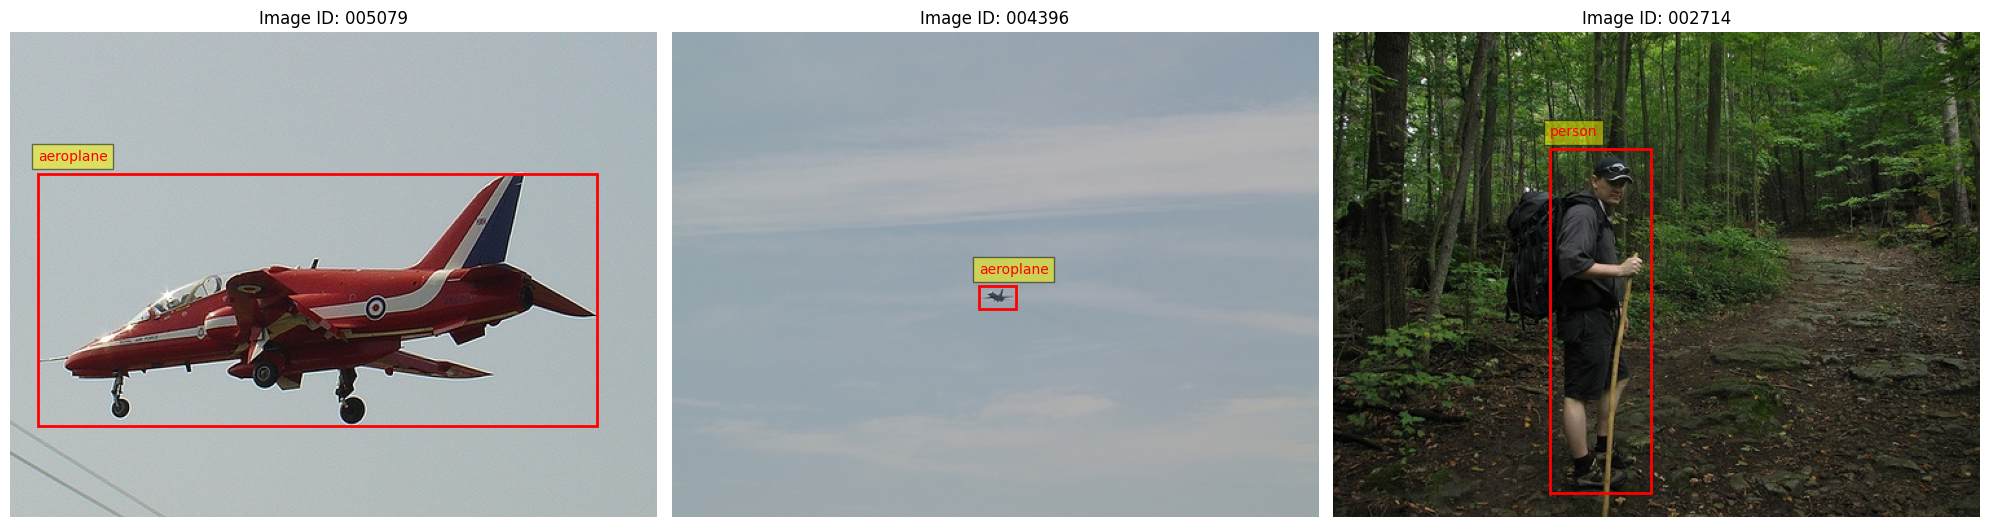

In [25]:
def plot_images_in_row(im_infos, label2idx):
    # Reverse the label2idx dictionary to map indices to class names
    idx2label = {v: k for k, v in label2idx.items()}

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    for i, ax in enumerate(axes): 
        im_info = im_infos[i]
        
        image = Image.open(im_info['filename'])
        ax.imshow(image)
        ax.set_title(f"Image ID: {im_info['img_id']}")
        ax.axis('off')  # Hide axes

        # Plot each bounding box and label
        for det in im_info['detections']:
            bbox = det['bbox']  # [xmin, ymin, xmax, ymax]
            label_idx = det['label']
            label = idx2label[label_idx]
            
            # Create a rectangle patch
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),  # (xmin, ymin)
                bbox[2] - bbox[0],  # width
                bbox[3] - bbox[1],  # height
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add the label
            ax.text(
                bbox[0],
                bbox[1] - 10,
                label,
                color='red',
                fontsize=10,
                bbox=dict(facecolor='yellow', alpha=0.5)
            )
    plt.tight_layout()
    plt.show()
plot_images_in_row(train_data, label2idx)
